In [3]:
import cv2
from PIL import ImageFont, ImageDraw, Image
import numpy as np
import time
import os
import matplotlib.pyplot as plt

In [4]:
# YOLO 설정 파일 Path
labelsPath = os.getcwd()+"\\df2.names" # Hand 라벨
weightsPath = os.getcwd()+"\\yolov3-df2_15000.weights" # 가중치
configPath = os.getcwd()+"\\yolov3-df2.cfg" # 모델 구성


In [5]:
# YOLO 라벨(hand) 호출
YOLO_LABELS = open(labelsPath).read().strip().split("\n")

# YOLO 모델 호출
yolo_net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# YOLO 출력층 설정
layer_names = yolo_net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in yolo_net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(YOLO_LABELS), 3))

In [6]:
print(YOLO_LABELS)

['short sleeve top', 'long sleeve top', 'short sleeve outwear', 'long sleeve outwear', 'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short sleeve dress', 'long sleeve dress', 'vest dress', 'sling dress']


In [7]:
frame_id = 0
count=0

In [46]:
img = cv2.imread('./test\\3.jpg', cv2.IMREAD_COLOR)
img_height, img_width, channels = img.shape
print(img.shape)


# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416),  swapRB=True, crop=False) #mean=(0,0,0)

yolo_net.setInput(blob)
outs = yolo_net.forward(output_layers)


# Showing informations on the screen
class_ids = []
confidences = [] 
boxes = []
print(len(outs))

for out in outs:
#     print(out[0])
    for detection in out:
#         print(detection)
        scores = detection[5:]
        class_id = np.argmax(scores)
#         print(class_id)
        confidence = scores[class_id]
#         print(confidence)
        if confidence > 0.1: # 0.6, 0.7 nms
            # Object detected
            print(detection)
            center_x = int(detection[0] * img_width)
            center_y = int(detection[1] * img_height)
            width = int(detection[2] * img_width)
            height = int(detection[3] * img_height)
#             print(center_y, height) #152 327
            
            # Rectangle coordinates
            xx = int(center_x - width / 2)
            yy = int(center_y - height / 2)
            
#             cv2.rectangle(img, (int(xx), int(yy)), (int(xx+width), int(yy+height)), color=(0,255,0), thickness=2)
#             img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
#             plt.imshow(img_rgb)

            boxes.append([xx, yy, width, height])
            confidences.append(float(confidence))
            class_ids.append(class_id)

#             crop_img = img[yy:yy + height, xx:xx + width]
#             cv2.imwrite('./imagecrop\\man'+str(count)+".jpg", crop_img)
#             count += 1
#             cv2.imwrite(os.getcwd()+"\\img\\hand_"+str(count)+".jpg", crop_img)
# print(class_ids)

for i in class_ids:
    print(YOLO_LABELS[i])
    

    


(365, 206, 3)
3
[0.48579422 0.20565835 0.77002156 0.3602473  0.98101854 0.
 0.8952812  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.5006891  0.5707654  0.47775167 0.5678004  0.95325327 0.
 0.         0.         0.         0.         0.         0.
 0.94661015 0.         0.         0.         0.         0.        ]
long sleeve top
trousers


In [47]:
print(boxes)
print()
print(confidences)

[[21, 9, 158, 131], [54, 104, 98, 207]]

[0.895281195640564, 0.946610152721405]


In [48]:
## NMS 처리하기
conf_threshold = 0.1
nms_threshold = 0.4
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

print(idxs)

[[1]
 [0]]


{'white': 4132, 'grey': 3581, 'black': 6476, 'beige': 0, 'brown': 0, 'blue': 0, 'navy': 141, 'purple': 1085, 'green': 0, 'red': 204, 'orange': 72, 'yellow': 0, 'pink': 140}
{'white': 1179, 'grey': 1814, 'black': 4943, 'beige': 0, 'brown': 0, 'blue': 401, 'navy': 269, 'purple': 920, 'green': 297, 'red': 1227, 'orange': 162, 'yellow': 0, 'pink': 204}
[{'trousers': 'black'}, {'long sleeve top': 'black'}]


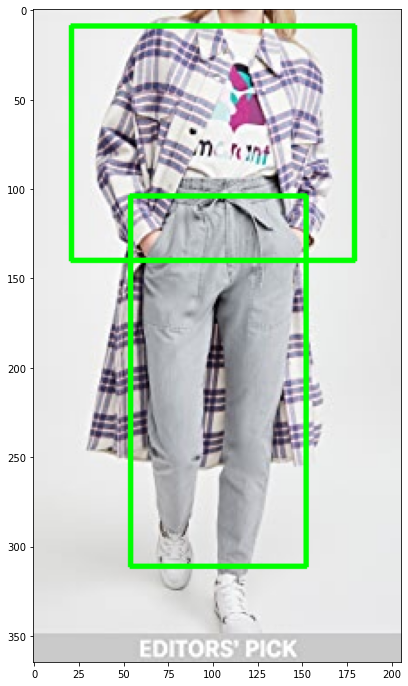

In [49]:
draw_img = img.copy()
count=0
feature_list = []

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        feature = {}
        box = boxes[i]
        if box[1] < 0: box[1] = 0
        if box[0] < 0: box[0] = 0
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
#         print(box)
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(YOLO_LABELS[class_ids[i]], confidences[i])
        feature[YOLO_LABELS[class_ids[i]]] = "N/A"
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=(0,255,0), thickness=2)
        
        crop_img = img[top:top + height, left:left + width]
#         print(detect_color(crop_img))
        feature[YOLO_LABELS[class_ids[i]]] = detect_color(crop_img)
#         print(class_ids[i])
#         cv2.imwrite('./imagecrop\\1_'+(YOLO_LABELS[class_ids[i]])+".jpg", crop_img)
        count += 1
        feature_list.append(feature)
else:
    feature["N/A"] = "N/A"
    feature_list.append(feature)

print(feature_list)
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [97]:
def calculate_area(image, image_area, color):
    result = 0
    kernal = np.ones((5, 5), 'uint8')

    # Convert BGR color space to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define masks for each color
    mask = cv2.inRange(hsv_image,
        LOWER_HSV[color], UPPER_HSV[color])

    # Create contour
    mask = cv2.dilate(mask, kernal)
    cv2.bitwise_and(image, image, mask=mask)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Track color
    for contour in contours:
        area = cv2.contourArea(contour)
        if (area > image_area * 0.001):
            _, _, w, h = cv2.boundingRect(contour)
            result += w*h

    return result

def detect_color(image_path, leftup=None, rightdown=None):
    # Get image
#     image = image_path
    image = cv2.imread(image_path)
    if leftup != None and rightdown != None:
        image = image[leftup[1]: rightdown[1], leftup[0]: rightdown[0]]

    height, width, _ = image.shape
    image_area = height * width

    # Calcuate color areas
    white_area = calculate_area(image, image_area, 'white')
    red_area = calculate_area(image, image_area, 'red')
    green_area = calculate_area(image, image_area, 'green')
    blue_area = calculate_area(image, image_area, 'blue')
    yellow_area = calculate_area(image, image_area, 'yellow')
    orange_area = calculate_area(image, image_area, 'orange')
    black_area = calculate_area(image, image_area, 'black')
    grey_area = calculate_area(image, image_area, 'grey')
    brown_area = calculate_area(image, image_area, 'brown')
    navy_area = calculate_area(image, image_area, 'navy')
    purple_area = calculate_area(image, image_area, 'purple')
    pink_area = calculate_area(image, image_area, 'pink')

    areas = {'white': white_area, 'grey': grey_area, 'black': black_area, 'brown': brown_area,
             'blue': blue_area, 'navy': navy_area, 'purple': purple_area, 'green': green_area, 'red': red_area,
             'orange': orange_area, 'yellow': yellow_area, 'pink': pink_area}
    
    return max(areas, key=lambda x : areas[x])

In [100]:
# color boundaries
LOWER_HSV = {
    'red': np.array([145, 100, 20], np.uint8),
    "orange": np.array([10, 100, 100], np.uint8),
    'yellow': np.array([17, 100, 20], np.uint8),
    'green': np.array([60, 100, 20], np.uint8),
    'blue': np.array([90, 100, 20], np.uint8),
    "navy": np.array([110, 100, 20], np.uint8),
    "purple": np.array([125, 100, 20], np.uint8),
    "pink": np.array([0, 70, 20], np.uint8),
    "black": np.array([0, 0, 0], np.uint8), 
    "white": np.array([0, 0, 50], np.uint8),
    "grey": np.array([0, 0, 150], np.uint8), ###
    "brown": np.array([10, 100, 20], np.uint8), ###
}

UPPER_HSV = {
    'red': np.array([180, 255, 255], np.uint8),
    "orange": np.array([20, 255, 255], np.uint8),
    'yellow': np.array([35, 255, 255], np.uint8),
    'green': np.array([90, 255, 255], np.uint8),
    'blue': np.array([110, 255, 255], np.uint8),
    "navy": np.array([125, 255, 255], np.uint8),
    "purple": np.array([135, 255, 255], np.uint8),
    "pink": np.array([6, 255, 250], np.uint8),
    "black": np.array([180, 60, 100], np.uint8), 
    "white": np.array([180, 40, 177], np.uint8),
    "grey": np.array([40, 30, 190], np.uint8), ###
    "brown": np.array([20, 255, 200], np.uint8) ###
}

In [101]:
print(detect_color('./imagecrop\\red.jpg')) 
print(detect_color('./imagecrop\\orange.jpg')) 
print(detect_color('./imagecrop\\yellow.jpg'))
print(detect_color('./imagecrop\\green.jpg')) 
print(detect_color('./imagecrop\\blue.jpg')) 
print(detect_color('./imagecrop\\navy.jpg')) 
print(detect_color('./imagecrop\\purple.jpg')) 
print(detect_color('./imagecrop\\pink.jpg')) 
print(detect_color('./imagecrop\\black.jpg')) 
print(detect_color('./imagecrop\\white.jpg')) 
print(detect_color('./imagecrop\\grey.jpg'))
print(detect_color('./imagecrop\\beige.jpg')) #
print(detect_color('./imagecrop\\brown.jpg')) #

red
orange
yellow
green
blue
navy
purple
pink
black
white
grey
white
brown
